# Climate Analysis and Exploration

Using sqlalcemy, pandas and matplotlib perform the analysis and exploration of climate data from the database.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Float, ForeignKey, Date, func 
from datetime import datetime
from collections import Counter
import numpy as np
from datetime import datetime, timedelta

In [2]:
engine = create_engine('sqlite:///hawaii.sqlite')
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [3]:
session = Session(engine)

In [4]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
max_dt = session.query(func.max(Measurement.date)).all()
end_dt = max_dt[0][0]
print(end_dt)
start_dt = end_dt.replace(year = (end_dt.year - 1))
print(start_dt)

2017-08-23
2016-08-23


### Precipitation Analysis

In [6]:
dt = []
prcptn = []
for row in session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(start_dt, end_dt)):
    dt.append(row.date)
    prcptn.append(float(row.prcp))

In [7]:
print(dt[:5])
print(prcptn[:5])

[datetime.date(2016, 8, 23), datetime.date(2016, 8, 24), datetime.date(2016, 8, 25), datetime.date(2016, 8, 26), datetime.date(2016, 8, 27)]
[0.0, 0.08, 0.08, 0.0, 0.0]


In [8]:
prcp_df = pd.DataFrame({"date": dt,
                  "precipitation": prcptn})

In [9]:
prcp_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [10]:
prcp_df = prcp_df.set_index(['date'])
prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


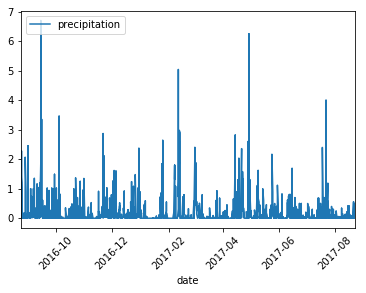

In [11]:
prcp_df.plot()
plt.xticks(rotation=45)
plt.legend(loc=2)
plt.show()

In [12]:
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [13]:
print("Total number of stations:", session.query(Station).count())

Total number of stations: 9


In [14]:
print("Stations with temperature observation counts in descending order")
staTempObs = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
staTempObs

Stations with temperature observation counts in descending order


[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2484),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 342)]

Station: WAIHEE 837.5, HI US has the highest number of observations i.e. 2772


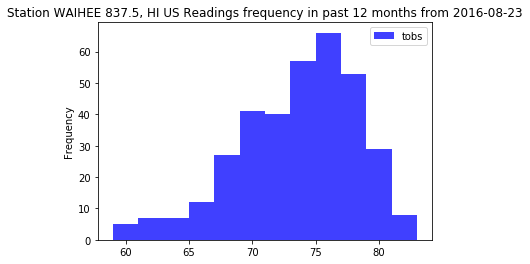

In [15]:
sta_id_obs_max = staTempObs[:1][0][0]
sta_name_obs_max = staTempObs[:1][0][1]
sta_name_obs_count = staTempObs[:1][0][2]
print("Station:", sta_name_obs_max, "has the highest number of observations i.e.", sta_name_obs_count)

temp_readings_1 = []
for row in session.query(Measurement.tobs).filter(Measurement.station==sta_id_obs_max, Measurement.date.between(start_dt, end_dt)).all():
    temp_readings_1.append(row.tobs)

plt.hist(temp_readings_1, 12, facecolor='blue', alpha=0.75)
plt.legend(loc=1, labels=['tobs'])
plt.ylabel('Frequency')
plt.title('Station ' +sta_name_obs_max + ' Readings frequency in past 12 months from ' + start_dt.strftime('%Y-%m-%d'))
plt.show()

Station: WAIKIKI 717.2, HI US has the highest number of observations i.e. 359 in past 12 months from 2016-08-23


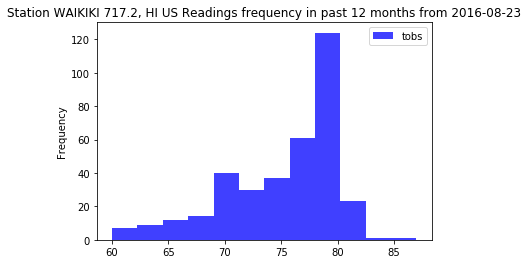

In [16]:
staWithMaxObs_12Months = session.query(Measurement.station.label('stationID'), Station.name.label('stationName'), func.count(Measurement.tobs).label('observationCount')).filter(Measurement.station == Station.station, Measurement.date.between(start_dt, end_dt)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()

print("Station:", staWithMaxObs_12Months.stationName, "has the highest number of observations i.e.", staWithMaxObs_12Months.observationCount, "in past 12 months from " + start_dt.strftime('%Y-%m-%d'))

temp_readings_2 = []
for row in session.query(Measurement.tobs).filter(Measurement.station==staWithMaxObs_12Months.stationID, Measurement.date.between(start_dt, end_dt)).all():
    temp_readings_2.append(row.tobs)

plt.hist(temp_readings_2, 12, facecolor='blue', alpha=0.75)
plt.legend(loc=1, labels=['tobs'])
plt.ylabel('Frequency')
plt.title('Station ' +staWithMaxObs_12Months.stationName + ' Readings frequency in past 12 months from ' + start_dt.strftime('%Y-%m-%d'))
plt.show()

### Temperature Analysis

In [17]:
def calc_temps(start_dt, end_dt):
    ref_start_dt = (datetime.strptime(start_dt,'%Y-%m-%d') - timedelta(days=365)).strftime('%Y-%m-%d')
    ref_end_dt = (datetime.strptime(end_dt,'%Y-%m-%d') - timedelta(days=365)).strftime('%Y-%m-%d')
    temp = session.query(func.max(Measurement.tobs).label('max_temp'), func.min(Measurement.tobs).label('min_temp'), func.avg(Measurement.tobs).label('avg_temp')).filter(Measurement.date.between(ref_start_dt, ref_end_dt)).first()
    print("Temperature within trip duration - Max Temp:", temp.max_temp, " Min Temp:", temp.min_temp, " Avg Temp:", temp.avg_temp)
    return temp

In [18]:
trip_temp_dtls = calc_temps('2017-10-25', '2017-11-05')
print(trip_temp_dtls)

Temperature within trip duration - Max Temp: 81  Min Temp: 68  Avg Temp: 75.9041095890411
(81, 68, 75.9041095890411)


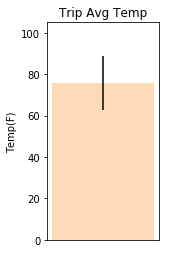

In [19]:
plt.figure(figsize=(2,4))
a = trip_temp_dtls.max_temp - trip_temp_dtls.min_temp
plt.bar(0, trip_temp_dtls.avg_temp, color='peachpuff', yerr=a)
plt.ylabel('Temp(F)')
plt.ylim(0,105)
plt.gca().axes.get_xaxis().set_ticks([])
plt.title('Trip Avg Temp')
plt.show()

### Rainfall Analysis

In [20]:
print("Stations with rainfall in descending order")
staPrcpObs = session.query(Measurement.station, func.sum(Measurement.prcp)).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
staPrcpObs

Stations with rainfall in descending order


[('USC00516128', 1068.0899999999956),
 ('USC00519281', 588.6399999999976),
 ('USC00513117', 382.61999999999847),
 ('USC00519523', 295.67999999999944),
 ('USC00514830', 234.49000000000026),
 ('USC00519397', 131.62000000000063),
 ('USC00511918', 92.68000000000006),
 ('USC00518838', 70.87000000000005),
 ('USC00517948', 43.44000000000002)]

In [21]:
def daily_normals(dt_lst):
    temp_min, temp_max, temp_avg = [], [], []
    for dt1 in dt_lst:
        dt1_str = '%-' + dt1[5:]
        temp = session.query(func.max(Measurement.tobs).label('max_temp'), func.min(Measurement.tobs).label('min_temp'), func.avg(Measurement.tobs).label('avg_temp')).filter(Measurement.date.like(dt1_str)).first()
        print("Estimated Temperatures for" , dt1, " - Max Temp:", temp.max_temp, " Min Temp:", temp.min_temp, " Avg Temp:", temp.avg_temp)
        temp_min.append(temp.min_temp)
        temp_max.append(temp.max_temp)
        temp_avg.append(float(temp.avg_temp))
    temp_lst = [temp_min, temp_max, temp_avg]
    return temp_lst

In [22]:
dt_lst_1 = ['2018-01-01','2018-01-02','2018-01-03','2018-01-04','2018-01-05','2018-01-06','2018-01-07']
temp_lst_1 = daily_normals(dt_lst_1)
temp_lst_1

Estimated Temperatures for 2018-01-01  - Max Temp: 77  Min Temp: 62  Avg Temp: 69.06
Estimated Temperatures for 2018-01-02  - Max Temp: 77  Min Temp: 60  Avg Temp: 69.40816326530613
Estimated Temperatures for 2018-01-03  - Max Temp: 77  Min Temp: 62  Avg Temp: 68.83333333333333
Estimated Temperatures for 2018-01-04  - Max Temp: 76  Min Temp: 58  Avg Temp: 69.83636363636364
Estimated Temperatures for 2018-01-05  - Max Temp: 76  Min Temp: 56  Avg Temp: 68.0
Estimated Temperatures for 2018-01-06  - Max Temp: 76  Min Temp: 61  Avg Temp: 68.88679245283019
Estimated Temperatures for 2018-01-07  - Max Temp: 76  Min Temp: 57  Avg Temp: 68.38181818181818


[[62, 60, 62, 58, 56, 61, 57],
 [77, 77, 77, 76, 76, 76, 76],
 [69.06,
  69.40816326530613,
  68.83333333333333,
  69.83636363636364,
  68.0,
  68.88679245283019,
  68.38181818181818]]

In [23]:
temp_df = pd.DataFrame({"date": dt_lst_1,
                  "tmin": temp_lst_1[0],
                   "tmax": temp_lst_1[1],
                   "tavg":temp_lst_1[2]})
temp_df = temp_df.set_index(['date'])
temp_df = temp_df[['tmin','tavg','tmax']]
temp_df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62,69.060000,77
2018-01-02,60,69.408163,77
2018-01-03,62,68.833333,77
2018-01-04,58,69.836364,76
2018-01-05,56,68.000000,76


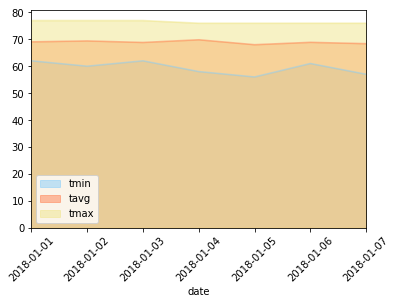

In [24]:
color_l = ['lightskyblue','coral','khaki']
temp_df.plot(kind='area', stacked=False, color=color_l)
plt.xticks(rotation=45)
plt.show()